**IMPORTING LIBRARIES**

In [ ]:
!pip install tensorflow scikeras scikit-learn
import os
import keras
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
#from keras.utils.np_utils import to_categorical
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import gridspec
from keras.layers import Conv2D, MaxPooling2D, Flatten



In [ ]:

print(keras.__version__)

print(tf.__version__)

2.14.0
2.14.0


**LOADING DATASET AND CREATING TRAINING AND TESTING SPLITS**

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The image dataset is loaded and turned into numpy arrays using their RGB values. Then the classes(benign and malignant)are assigned labels(0 or 1).The values are shuffled and split into training and testing.

In [ ]:
data='/content/drive/MyDrive/Final Skin Cancer/data'
benign_train = '/content/drive/MyDrive/Final Skin Cancer/data/train/benign'
malignant_train = '/content/drive/MyDrive/Final Skin Cancer/data/test/malignant'

benign_test = '/content/drive/MyDrive/Final Skin Cancer/data/test/benign'
malignant_test = '/content/drive/MyDrive/Final Skin Cancer/data/test/malignant'


**Loading the Resnet pretrained model**

In [ ]:
#Loading ResNet50 with imagenet weights, include_top means that we loading model without last fully connected layers
model = ResNet50(weights = 'imagenet', include_top = False)


**Data Preprocessing and feature extraction**

In [ ]:
# Read image
orig = cv.imread('/content/drive/MyDrive/Final Skin Cancer/data/train/benign/100.jpg')

# Convert image to RGB from BGR (another way is to use "image = image[:, :, ::-1]" code)
orig = cv.cvtColor(orig, cv.COLOR_BGR2RGB)

# Resize image to 224x224 size
image = cv.resize(orig, (224, 224)).reshape(-1, 224, 224, 3)

# We need to preprocess imageto fulfill ResNet50 requirements
image = preprocess_input(image)

# Extracting our features
features = model.predict(image)

features.shape

1/1 [==============================] - 1s 1s/step


(1, 7, 7, 2048)

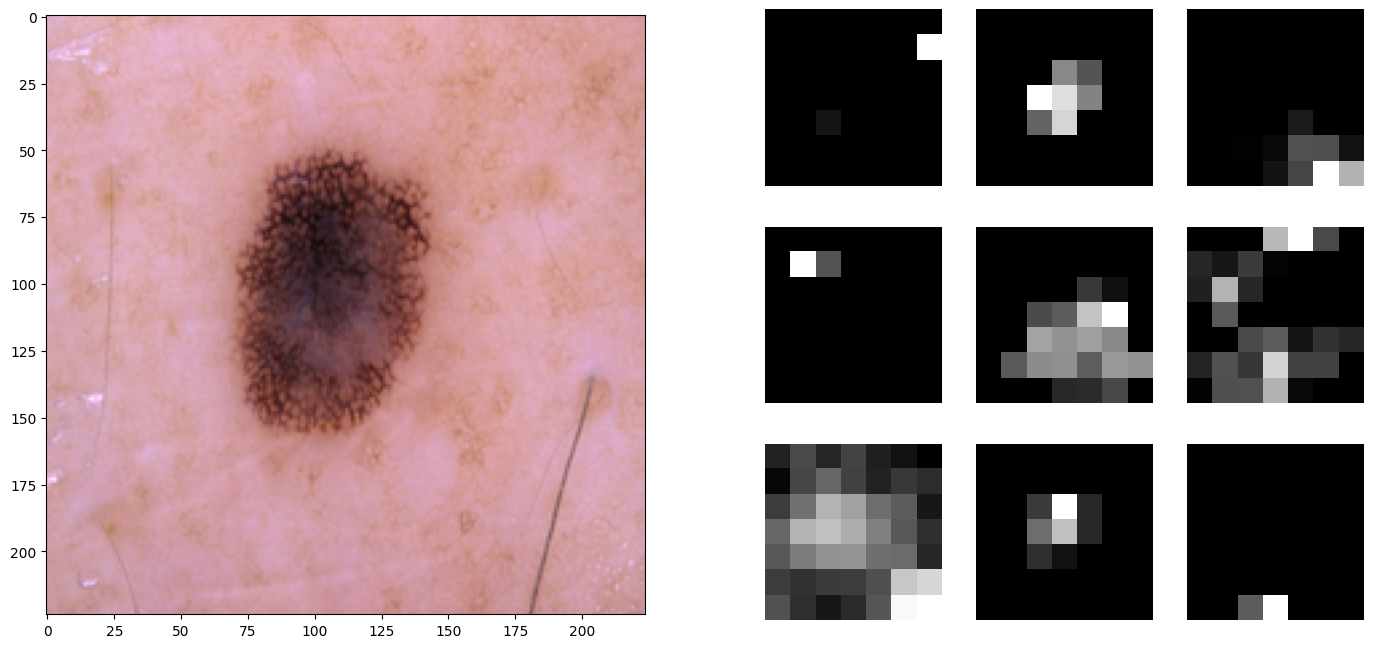

In [ ]:
n_features = features.shape[-1]

fig = plt.figure(figsize = (17, 8))
gs = gridspec.GridSpec(1, 2, figure = fig)
sub_gs = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[1])

ax1 = fig.add_subplot(gs[0])
ax1.imshow(orig)

for i in range(3):
    for j in range(3):
        ax2 = fig.add_subplot(sub_gs[i, j])
        plt.axis('off')
        plt.imshow(features[0, :, :, np.random.randint(n_features)], cmap = 'gray')

In [ ]:
# List of splts: ['training', 'validation', 'evaluation']
data='/content/drive/MyDrive/Final Skin Cancer/data'
sets = os.listdir(data)

# Arrays to store data
#X_train, y_train = ([], [])
#X_test, y_test = ([], [])
#eval_X, eval_Y = ([], [])

#new_data = [(X_train, y_train), (X_test, y_test), (eval_X, eval_Y)]
features_list, label_list = [], []
# Loop through all splits
for s in sets:
    # Defining path to categories ['non_food', 'food']
    path_to_cat = os.path.join(data, s)

 # Loop through categories in split
    for category in os.listdir(path_to_cat):
        # Defining path to images in category
        path_to_images = os.path.join(path_to_cat, category)

        # Defining labels
        if category == 'Benign':
            label = 1
        else:
            label = 0

        # Loop through images in category
        for i in os.listdir(path_to_images):
            # Path to image
            image_path = os.path.join(path_to_images, i)

            # Reading and preprocessing image
            image = cv.imread(image_path)
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            image = cv.resize(image, (224, 224)).reshape(-1, 224, 224, 3)
            image = preprocess_input(image)

            # Extracting features
            features = model.predict(image).reshape(100352)
            features_list.append(features)
            label_list.append(label)


            # Store features and label in our lists
            #d[0].append(features)
            #d[1].append(label)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_list, label_list, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2/(0.6+0.2), random_state=42)

In [ ]:
# Converting data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_eval = np.array(X_eval)
y_eval = np.array(y_eval)

In [ ]:
print("Shape of eval_X:", X_eval.shape)
print("Shape of eval_Y:", y_eval.shape)

Shape of eval_X: (660, 1, 2)
Shape of eval_Y: (660,)


**MODEL 1: USING RESNET ENTIRELY TO TRAIN THE MODEL**

In [ ]:
model = Sequential()
model.add(Dense(256, input_shape = (100352,), activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(16, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(1, activation = 'sigmoid'))

# Checkpoint to save best model
checkpoint = ModelCheckpoint('best_final_model.h5', monitor = 'val_accuracy', verbose = 1, save_best_only = True)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size = 64, epochs = 50, validation_data = [X_test, y_test], callbacks = [checkpoint])

Epoch 1/50
30/31 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.9833
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_final_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 3s 64ms/step - loss: 0.0255 - accuracy: 0.9838 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/50
28/31 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
31/31 [==============================] - 1s 18ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/50
28/31 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
31/31 [==============================] - 1s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 1.00000
31/31 [==============================] - 1s 18ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch

In [ ]:
model.load_weights('best_final_model.h5')
model.evaluate(X_eval, y_eval)

21/21 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

In [ ]:
#Confusion model
y_pred = model.predict(X_eval)  # Get predicted probabilities for each class
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to predicted class labels

21/21 [==============================] - 0s 6ms/step


In [ ]:
cm = confusion_matrix(y_eval, y_pred_labels)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[660]]


In [ ]:
from sklearn.metrics import precision_score
precision = precision_score(y_eval, y_pred_labels)
print("Precision:", precision)


Precision: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


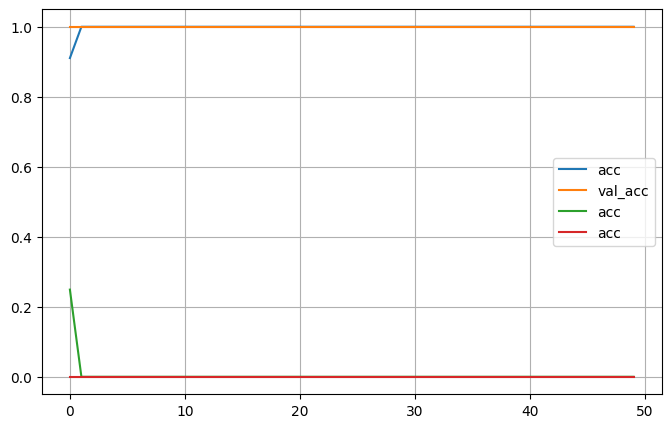

In [ ]:
# Plot losses and accuracies
history = model.history.history

fig = plt.figure(figsize = (8, 5))
plt.plot(history['accuracy'], label = 'acc')
plt.plot(history['val_accuracy'], label = 'val_acc')
plt.plot(history['loss'], label = 'acc')
plt.plot(history['val_loss'], label = 'acc')
plt.grid()
plt.legend()
plt.show()